In [ ]:
from utils import *
import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.utils import degree
from sklearn.model_selection import train_test_split
import pandas as pd
import copy

class CancerDataset(InMemoryDataset):
    def __init__(self, data_obj, test_size=None, transform=None):
        super(MazeDataset, self).__init__(data_obj, transform, None, None)
        self.data_obj = copy.deepcopy(data_obj)
        
        self.data_obj.num_nodes = len(self.data_obj.x)
        #normalize x
        original_x = copy.deepcopy(data_obj.x)
        self.data_obj['scaler'] = original_x.max()-original_x.min()
        self.data_obj['shift'] = original_x.mean()
        self.data_obj.x = (original_x-self.data_obj['shift'])/self.data_obj['scaler']
        if test_size is not None:
            assert (test_size>0)&(test_size<1), 'Invalid test size. It needs to be 0 < test_size < 1.'
            # splitting the data into train, validation and test
            X_train, X_test = train_test_split(pd.Series(range(self.data_obj.num_nodes)), 
                                                                test_size=test_size, 
                                                                random_state=42)


            # create train and test masks for data
            train_mask = torch.zeros(self.data_obj.num_nodes, dtype=torch.bool)
            test_mask = torch.zeros(self.data_obj.num_nodes, dtype=torch.bool)
            train_mask[X_train.index] = True
            test_mask[X_test.index] = True
            self.data_obj['train_mask'] = train_mask
            self.data_obj['test_mask'] = test_mask
        else:
            train_mask = torch.ones(self.data_obj.num_nodes, dtype=torch.bool)
            self.data_obj['train_mask'] = train_mask

        self.data, self.slices = self.collate([self.data_obj])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)    
    
    
def create_data(args, verbose=True):  
 
    maze_orig = image2maze(args.imgpath, start=args.start, goal=args.goal, startlayer=startlayer, goallayer=goallayer)
    mz = coarse_map(maze_orig,args.poolsize)
    node_coords = np.argwhere(1-mz[:,:,2])
    t0 = time.perf_counter()
    edges, edge_features = extract_edges_and_features_from_image(node_coords, verbose)
    t1 = time.perf_counter()
    
#     if verbose: 
#         print(t1-t0, 'Edges and edge features extracted from func:extract_edges_and_features_from_image.')
    
    edge_index = torch.tensor(edges, dtype=torch.long)
    edge_features = torch.tensor(edge_features, dtype=torch.long)
    node_features = node_features = torch.tensor(node_coords, dtype=torch.float)  #here we use coordinate as node feature

    data = Data(x=node_features, edge_index=edge_index.t().contiguous(), edge_features = edge_features)

    return data
    
def create_dataset(args, verbose=False):
    data = create_data(args, verbose)
    try:
        test_size = args.test_size
    except AttributeError:
        test_size = None
        
    dataset = CancerDataset(data,test_size=test_size)
    return dataset

In [25]:
import pandas as pd
#import HumanNet PPI
HN = pd.read_csv('data/HumanNet/HS-PI.tsv',delimiter='\t',header=None)
nid = set(list(HN[0])+list(HN[1]))

#import RH-edges
RH = pd.read_csv('data/NPInter_v4/processed/RHclean.csv')
R = set(list(RH.ncEz))
H = set(list(RH.tarEz))
#import cancer labels
cancer = pd.read_csv("data/DisGeNet/ovarian_cancer.csv")
cid = set(list(cancer.EntrezID.unique()))

In [26]:
cancer_gene_ids = sorted(list(H.intersection(cid)))
len(cancer_gene_ids)

1266

In [27]:
len(HN)

633460

In [31]:
HNsub = HN[(HN[0].isin(H))&(HN[1].isin(H))]
print(len(HNsub),len(set(list(HNsub[0])+list(HNsub[1])))) 
#edges reduces to 30%. Cora dataset has 2708 nodes and 10556 edges. This data is still much bigger (10x+) in edges

188045 7058


In [33]:
nodes = sorted(list(set(list(HNsub[0])+list(HNsub[1]))))

In [37]:
id2idx = dict(zip(nodes, list(range(len(nodes)))))
idx2id = dict(zip(list(range(len(nodes))),nodes))

In [46]:
HNsub = HNsub.rename(columns={0:'n1_Ez',1:'n2_Ez',2:'weight'})
HNsub

n1_Ez  n2_Ez    weight
1        4193   7157  4.902603
2        3091   7428  4.901923
3        3551   4792  4.900583
4        2475  57521  4.900516
7         997   9978  4.899791
...       ...    ...       ...
633452  22907    821  1.772873
633454    328   8379  1.772848
633455   2932   4704  1.772843
633457   6139  81533  1.772840
633458   3192   6133  1.772839

[188045 rows x 3 columns]

In [47]:
HNsub['n1_idx'] = HNsub['n1_Ez'].apply(lambda x: id2idx[x])
HNsub['n2_idx'] = HNsub['n2_Ez'].apply(lambda x: id2idx[x])
HNsub

n1_Ez  n2_Ez    weight  n1_idx  n2_idx
1        4193   7157  4.902603    1103    2040
2        3091   7428  4.901923     822    2130
3        3551   4792  4.900583     923    1245
4        2475  57521  4.900516     681    5036
7         997   9978  4.899791     281    2847
...       ...    ...       ...     ...     ...
633452  22907    821  1.772873    3406     218
633454    328   8379  1.772848      90    2290
633455   2932   4704  1.772843     782    1211
633457   6139  81533  1.772840    1683    5629
633458   3192   6133  1.772839     858    1678

[188045 rows x 5 columns]

In [50]:
lab=[1 if x in cid else 0 for x in nodes]
dflabel = pd.DataFrame(list(zip(nodes,lab)),columns={'Ez','cancer'})

In [51]:
dflabel

Ez  cancer
0            20       1
1            22       0
2            23       0
3            25       1
4            26       0
...         ...     ...
7053  100506658       1
7054  100507290       0
7055  100526737       0
7056  100529063       0
7057  100652748       0

[7058 rows x 2 columns]

In [52]:
dflabel.cancer.sum()

1260

In [53]:
dflabel['node_idx'] = dflabel['Ez'].apply(lambda x: id2idx[x])

In [54]:
dflabel

Ez  cancer  node_idx
0            20       1         0
1            22       0         1
2            23       0         2
3            25       1         3
4            26       0         4
...         ...     ...       ...
7053  100506658       1      7053
7054  100507290       0      7054
7055  100526737       0      7055
7056  100529063       0      7056
7057  100652748       0      7057

[7058 rows x 3 columns]

In [65]:
PPI = HNsub[['n1_idx','n2_idx','weight']].sort_values(by='n1_idx')
edges = PPI[['n1_idx','n2_idx']].values.T
edge_weights = PPI['weight'].values
print(edges.shape, edge_weights.shape)

(2, 188045) (188045,)


(array([144623.,  16025.,  10179.,   5771.,   3170.,   2223.,   1848.,
          1597.,   1453.,   1156.]),
 array([1.77283873, 2.08581516, 2.39879158, 2.71176801, 3.02474444,
        3.33772086, 3.65069729, 3.96367372, 4.27665014, 4.58962657,
        4.902603  ]),
 <BarContainer object of 10 artists>)

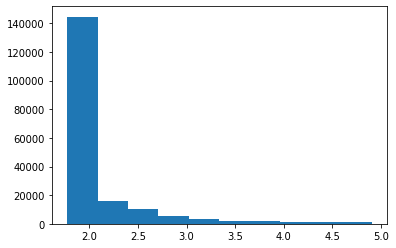

In [66]:
import matplotlib.pyplot as plt
plt.hist(edge_weights)

In [67]:
labels = dflabel.cancer.values

In [68]:
RH

Unnamed: 0       ncEz   tarEz
0             296  100379571   23621
1             297  100379571     351
2             310     400500    2130
3             312     400500   79753
4             513        618    1973
...           ...        ...     ...
75359      536405     406952     331
75360      536409     406952   57826
75361      536417     406952    6134
75362      539035     406952  144699
75363      539037     407050  144699

[75364 rows x 3 columns]

In [74]:
RHnodes = sorted(list(R.union(H)))
len(RHnodes)

11166

In [82]:
# Need to filter RH to Hs that are in PPI subnetwork
RHsub = RH[RH.tarEz.isin(nodes)]
print(len(RHsub))
R = set(RHsub.ncEz.values)
print(len(R))
#rnode indices are different from the sample indices. it's feature index
#Rnodes->features
#Hnodes->samples (nodes)
rnodes = sorted(list(R))
print(len(rnodes))
id2fidx = dict(zip(rnodes, list(range(len(rnodes)))))
fidx2id = dict(zip(list(range(len(rnodes))),rnodes))

75137
4031
4031


In [85]:
import numpy as np
featuremat = np.zeros((len(nodes),len(rnodes)))


RHsub['tar_idx'] = RHsub['tarEz'].apply(lambda x: id2idx[x])
RHsub['nc_idx'] =  RHsub['ncEz'].apply(lambda x: id2fidx[x])
RHsub

/tmp/ipykernel_16019/2284787664.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RHsub['tar_idx'] = RHsub['tarEz'].apply(lambda x: id2idx[x])
/tmp/ipykernel_16019/2284787664.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RHsub['nc_idx'] =  RHsub['ncEz'].apply(lambda x: id2fidx[x])


Unnamed: 0       ncEz   tarEz  tar_idx  nc_idx
0             296  100379571   23621     3701    2394
1             297  100379571     351       98    2394
2             310     400500    2130      621    1163
3             312     400500   79753     5457    1163
4             513        618    1973      561       8
...           ...        ...     ...      ...     ...
75359      536405     406952     331       93    1255
75360      536409     406952   57826     5113    1255
75361      536417     406952    6134     1679    1255
75362      539035     406952  144699     6381    1255
75363      539037     407050  144699     6381    1291

[75137 rows x 5 columns]

In [86]:
len(nodes)

7058

In [89]:
for row in RHsub[['tar_idx','nc_idx']].sort_values(by='tar_idx').values:
    featuremat[row[0],row[1]]=1

In [91]:
featuremat.sum()

75137.0

In [98]:
featuremat.shape

(7058, 4031)

In [104]:
from collections import Counter
Counter(featuremat.astype(int).sum(axis=1)) #there are some celebrity genes which degrees isa few thousands.

Counter({2: 1124,
         1: 2730,
         4: 308,
         15: 73,
         19: 47,
         24: 23,
         3: 478,
         33: 11,
         12: 102,
         36: 9,
         7: 194,
         14: 76,
         436: 1,
         5: 319,
         10: 132,
         27: 15,
         20: 42,
         6: 248,
         43: 10,
         16: 64,
         17: 71,
         18: 52,
         49: 2,
         8: 184,
         21: 24,
         13: 92,
         28: 20,
         23: 23,
         29: 11,
         11: 112,
         41: 10,
         26: 24,
         9: 129,
         73: 2,
         37: 10,
         46: 5,
         22: 28,
         25: 22,
         61: 3,
         493: 2,
         30: 18,
         352: 1,
         45: 4,
         203: 2,
         31: 11,
         91: 1,
         40: 2,
         241: 1,
         147: 2,
         164: 2,
         1154: 1,
         596: 1,
         111: 1,
         197: 2,
         2458: 1,
         236: 1,
         129: 2,
         721: 1,
         101: 1

In [105]:
featuremat.astype(int).sum(axis=1).min() #make sure all genes have degree at least 1

1

In [106]:
(featuremat.astype(int).sum(axis=1)==1).sum() #2730 genes out of 7058 genes have only degree of 1

2730

In [108]:
np.median(featuremat.astype(int).sum(axis=1)) #median degree=2

2.0

In [109]:
np.mean(featuremat.astype(int).sum(axis=1)) #mean degree 10.6

10.645650325871351